In [1]:
!ls "../raw_custom_data/AWS_AI_Preliminary_Contest/data/04003906/Camera1/1"

1.png  13.png 17.png 20.png 24.png 28.png 31.png 35.png 39.png 6.png
1.xml  13.xml 17.xml 20.xml 24.xml 28.xml 31.xml 35.xml 39.xml 6.xml
10.png 14.png 18.png 21.png 25.png 29.png 32.png 36.png 4.png  7.png
10.xml 14.xml 18.xml 21.xml 25.xml 29.xml 32.xml 36.xml 4.xml  7.xml
11.png 15.png 19.png 22.png 26.png 3.png  33.png 37.png 40.png 8.png
11.xml 15.xml 19.xml 22.xml 26.xml 3.xml  33.xml 37.xml 40.xml 8.xml
12.png 16.png 2.png  23.png 27.png 30.png 34.png 38.png 5.png  9.png
12.xml 16.xml 2.xml  23.xml 27.xml 30.xml 34.xml 38.xml 5.xml  9.xml


In [2]:
from glob import glob
base_url = '../raw_custom_data/AWS_AI_Preliminary_Contest/data'
pngs = glob(base_url + '/*/*/*/*.png')
xmls = glob(base_url + '/*/*/*/*.xml')

In [3]:
pngs[0],xmls[0]

('../raw_custom_data/AWS_AI_Preliminary_Contest/data/4710126100923/Camera1/9/8.png',
 '../raw_custom_data/AWS_AI_Preliminary_Contest/data/4710126100923/Camera1/9/8.xml')

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
%matplotlib inline

In [5]:
def removeAxeEdge(ax):
    for loc, spine in ax.spines.items():
        spine.set_color('none')
        
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])

In [11]:
import re
from tqdm import tqdm
widths = []
heights = []
lefts = []
bottoms = []

for idx in tqdm(range(len(xmls))):
    
    
    with open(xmls[idx], 'r') as f:
        text = f.read()
    # print("text= ", text)
    p_name = re.compile("<name>\s*(.*)\s*</name>")
    result = p_name.search(text)
    name = result.group(1)

    p_xmin = re.compile("<xmin>\s*(.*)\s*</xmin>")
    result = p_xmin.search(text)
    xmin = result.group(1)

    p_xmax = re.compile("<xmax>\s*(.*)\s*</xmax>")
    result = p_xmax.search(text)
    xmax = result.group(1)

    p_ymin = re.compile("<ymin>\s*(.*)\s*</ymin>")
    result = p_ymin.search(text)
    ymin = result.group(1)

    p_ymax = re.compile("<ymax>\s*(.*)\s*</ymax>")
    result = p_ymax.search(text)
    ymax = result.group(1)

    p_width = re.compile("<width>\s*(.*)\s*</width>")
    result = p_width.search(text)
    img_width = result.group(1)

    p_height = re.compile("<height>\s*(.*)\s*</height>")
    result = p_height.search(text)
    img_height = result.group(1)

    bottom = float(ymax) / float(img_height)
    left = float(xmin) / float(img_width)
    width = abs(float(xmax) - float(xmin)) / float(img_width)
    height = abs(float(ymax) - float(ymin)) / float(img_height)
    img_height = float(img_height)
    img_width = float(img_width)
    
    
    widths.append(width)
    heights.append(height)
    lefts.append(left)
    bottoms.append(bottom)


100%|██████████| 29828/29828 [00:01<00:00, 15674.83it/s]


In [7]:
# import numpy as np
# widths = np.array(widths)

# tot = np.where((widths > 0) & (widths < 1))[0].shape[0]
# np.where((widths > 0.1) & (widths < 0.2))[0].shape[0] /tot

0.5392919404586295

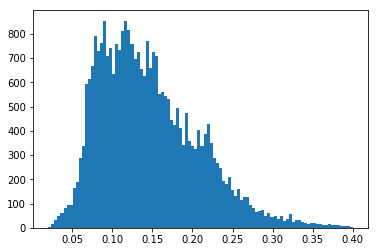

In [8]:
from matplotlib.pyplot import hist
n,bins,paths = hist(widths, bins=100, range=(0.02,0.4))

width , heigh = 187 , 155


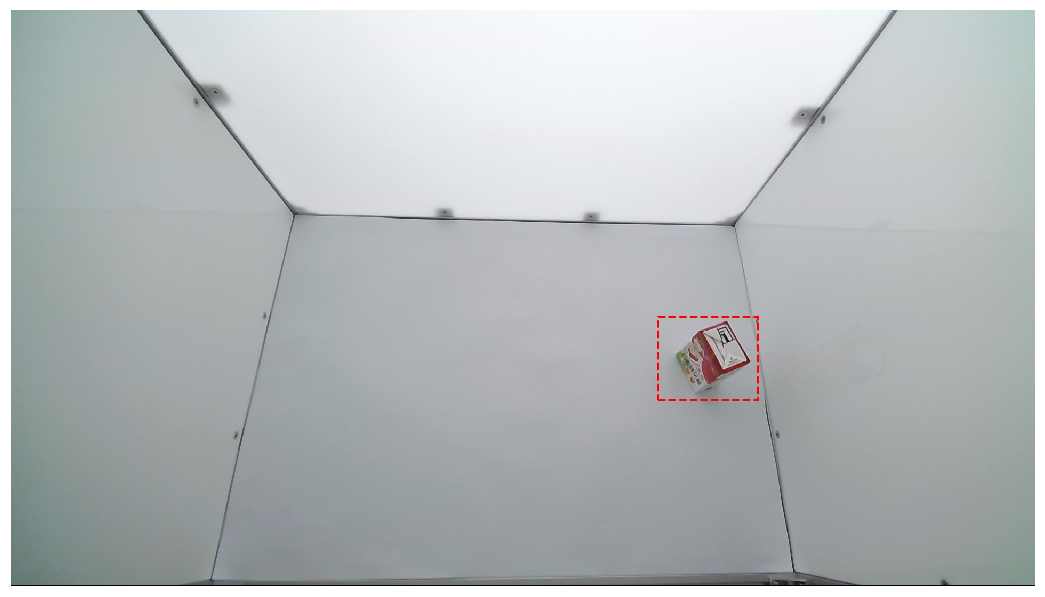

In [14]:
idx = 100

fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0,0,1,1])
removeAxeEdge(ax)

# axes coordinates are 0,0 is bottom left and 1,1 is upper right
p = patches.Rectangle((lefts[idx], 1.0 - bottoms[idx]), widths[idx], heights[idx], fill=False, transform=ax.transAxes, clip_on=False, color='r', ls = '--', lw = 2)
ax.add_patch(p)
    
img = mpimg.imread(pngs[idx])
plt.imshow(img)
print('width , heigh = {:.0f} , {:.0f}'.format(widths[idx] * img_width, heights[idx] * img_height))
